<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/vopo/finding_postion_of_tumor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 36.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries

In [ ]:
import re
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib


Data path of the images

In [ ]:
TRAIN_DATASET_PATH = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/images_structural" +'/'
MASK = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/automated_segm"+'/'


loading the images

In [ ]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'UPENN-GBM-00019_11/UPENN-GBM-00019_11_FLAIR.nii').get_fdata()
#test_mask=nib.load(MASK + 'UPENN-GBM-00019_11_automated_approx_segm.nii').get_fdata()

The below function is to calculate the centroid with the intensity of different voxel

In [ ]:
def calculate_centroid(volume_data):

    # Initialize variables for centroid coordinates
    x_centroid = 0
    y_centroid = 0
    z_centroid = 0

    # Calculate the centroid coordinates
    for x in range(volume_data.shape[0]):
        for y in range(volume_data.shape[1]):
            for z in range(volume_data.shape[2]):
                voxel_value = volume_data[x, y, z]
                x_centroid += x * voxel_value
                y_centroid += y * voxel_value
                z_centroid += z * voxel_value

    # Divide by the total volume to get the centroid coordinates
    x_centroid /= np.sum(volume_data)
    y_centroid /= np.sum(volume_data)
    z_centroid /= np.sum(volume_data)

    centroid = (x_centroid, y_centroid, z_centroid)
    return centroid


Calculating the centroid the brian and coordinate of tumor voxels

In [ ]:
def centroid_and_coordinates(image_data):
  x = calculate_centroid(image_data)
  y = np.argwhere(image_data)
  return x,y


below funciton use to calculation the min coordinates and max coordinates of each axis  

In [ ]:
def compute_min_max(array2,a):
  x=[]
  for i in range(0,array2.shape[0]-1):
    x.append(array2[i][a])
  min_data = np.min(x)
  max_data = np.max(x)
  return min_data,max_data

def range_of_xyz(array):
  min_x, max_x = compute_min_max(array,0)
  size_x = max_x-min_x
  min_y, max_y = compute_min_max(array,1)
  size_y = max_y-min_y
  min_z, max_z = compute_min_max(array,2)
  size_z = max_z-min_z
  return [min_x,max_x], [min_y,max_y], [min_z,max_z]


According to the min max coordinates of each axis we scaled the brain anatomiacal regions

In [ ]:
def normalize_anatomical_regions(anatomical_regions, initial_size_brain, range_x, range_y, range_z):
    x_coords = []
    y_coords = []
    z_coords = []

    for region, centroid_coords in anatomical_regions.items():
        x_coords.append(centroid_coords[0])
        y_coords.append(centroid_coords[1])
        z_coords.append(centroid_coords[2])

    for i in range(len(z_coords)):
        x_coords[i] = x_coords[i] - 0 * (range_x[0] - range_x[1]) / (initial_size_brain[0] - 0) + range_x[0]
        y_coords[i] = y_coords[i] - 0 * (range_y[0] - range_y[1]) / (initial_size_brain[1] - 0) + range_y[0]
        z_coords[i] = z_coords[i] - 0 * (range_z[0] - range_z[1]) / (initial_size_brain[2] - 0) + range_z[0]

    # Update the centroid coordinates in the anatomical_regions dictionary
    normalized_regions = {}
    for i, (region, _) in enumerate(anatomical_regions.items()):
        normalized_regions[region] = (x_coords[i], y_coords[i], z_coords[i])

    return normalized_regions



Finding The tumor loaction using the tumor coordinates and the the normalized regions measuring the distance between the region of brain with each coordinates of the tumor and choosing the loaction with the minimum distance

In [ ]:
# Compare tumor centroid with anatomical regions
def tumor_location(regions,tumor_coords):
  closest_region = None
  min_distance = float('inf')
  for region, centroid_coords in regions.items():
    distance = np.linalg.norm(np.array(centroid_coords) - tumor_coords)
    if distance < min_distance:
        min_distance = distance
        closest_region = region
  return closest_region



Fetching out the IDS

In [ ]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_data_ids = [f.path for f in os.scandir(TRAIN_DATASET_PATH)]

train_data_mask_ids = [f.path for f in os.scandir(MASK)]

train_data_mask_ids.sort()
train_data_ids.sort()

mask_ids = []
for i in range(len(train_data_mask_ids)):
  test = train_data_mask_ids[i].split('_automated_approx_segm.nii')[0]
  test1 = test.split('/automated_segm/')[1]
  mask_ids.append(test1)

train_ids = []
for i in range(len(train_data_ids)):
  x = train_data_ids[i].split("/images_structural/")[1]
  train_ids.append(x)

result = []
for i in train_ids:
    if i not in mask_ids:
      result.append(i)

for i in result:
  train_ids.remove(i)

In [ ]:
train_ids.sort()
print(len(train_ids))


611


In [ ]:
initial_size_brain = [148, 172, 141]

anatomical_regions = {
    "Initiating and Controlling Movement Area": (20, 108, 90),
    "Tactile Sensation Processing Area": (46, 16, 60),
    "Visual Information Processing Center": (129, 98, 4),
    "Auditory Perception Center": (4, 99, 69),
    "Speech Production Center": (18, 126, 102),
    "Language Comprehension Center": (40, 126, 102),
    "Executive Function and Decision-Making Area": (22, 154, 82),
    "Memory Formation Center": (109, 60, 68),
    "Motor Control and Habit Formation Area": (98, 65, 65),
    "Balance and Coordination Center": (119, 25, 20),
    "Sensory and Motor Signal Relay Center": (73, 76, 70),
    "Emotion Processing Center": (47, 64, 70)
}
brain_centroid, brain_coordinates = centroid_and_coordinates(test_image_flair)
range_x,range_y,range_z = range_of_xyz(brain_coordinates)
normalized_regions = normalize_anatomical_regions(anatomical_regions, initial_size_brain, range_x, range_y, range_z)

In [ ]:
print(range_x,range_y,range_z)

[54, 183] [45, 214] [6, 143]


In [ ]:
normalized_regions

{'Initiating and Controlling Movement Area': (74.0, 153.0, 96.0),
 'Tactile Sensation Processing Area': (100.0, 61.0, 66.0),
 'Visual Information Processing Center': (183.0, 143.0, 10.0),
 'Auditory Perception Center': (58.0, 144.0, 75.0),
 'Speech Production Center': (72.0, 171.0, 108.0),
 'Language Comprehension Center': (94.0, 171.0, 108.0),
 'Executive Function and Decision-Making Area': (76.0, 199.0, 88.0),
 'Memory Formation Center': (163.0, 105.0, 74.0),
 'Motor Control and Habit Formation Area': (152.0, 110.0, 71.0),
 'Balance and Coordination Center': (173.0, 70.0, 26.0),
 'Sensory and Motor Signal Relay Center': (127.0, 121.0, 76.0),
 'Emotion Processing Center': (101.0, 109.0, 76.0)}

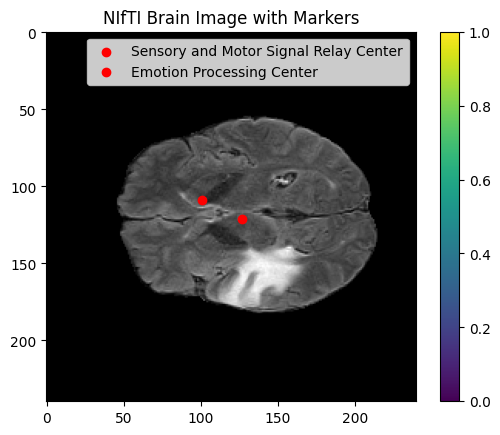

In [ ]:
# Display a slice of the image (e.g., the middle slice)
slice_index = 76  # Assuming you want to display the middle slice
plt.imshow(test_image_flair[:, :, slice_index], cmap='gray')

for name, (x, y, z) in normalized_regions.items():
  if z == slice_index:
    plt.scatter(x, y, color='red', marker='o', label=name)

plt.title('NIfTI Brain Image with Markers')
plt.colorbar()
plt.legend()
plt.show()


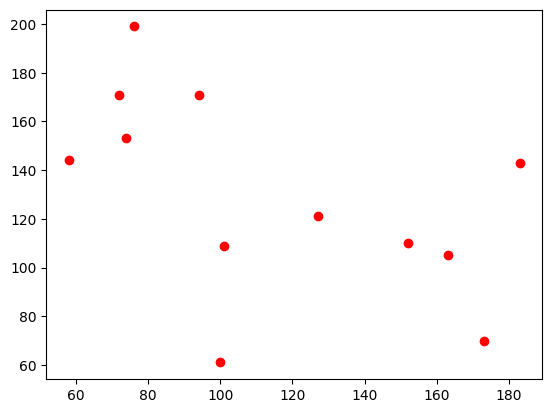

In [ ]:
# Mark the specified coordinates with names


Complete the process for 611 images to measure the tumor location

In [ ]:
# Example usage
initial_size_brain = [148, 172, 141]

anatomical_regions = {
    "Initiating and Controlling Movement Area": (20, 108, 90),
    "Tactile Sensation Processing Area": (46, 16, 60),
    "Visual Information Processing Center": (129, 98, 4),
    "Auditory Perception Center": (4, 99, 69),
    "Speech Production Center": (18, 126, 102),
    "Language Comprehension Center": (40, 126, 102),
    "Executive Function and Decision-Making Area": (22, 154, 82),
    "Memory Formation Center": (109, 60, 68),
    "Motor Control and Habit Formation Area": (98, 65, 65),
    "Balance and Coordination Center": (119, 25, 20),
    "Sensory and Motor Signal Relay Center": (73, 76, 70),
    "Emotion Processing Center": (47, 64, 70)
}


list_regions = []
for i in range(len(train_ids)):
  case_path0 = os.path.join(TRAIN_DATASET_PATH, train_ids[i] )
  data_path0 = os.path.join(case_path0, f'{train_ids[i]}_FLAIR.nii')
  case_path1 = os.path.join(MASK)
  data_path1 = os.path.join(case_path1, f'{train_ids[i]}_automated_approx_segm.nii')
  mask = nib.load(data_path1).get_fdata()
  image = nib.load(data_path0).get_fdata()
  tumor_centroid, tumor_coordinates = centroid_and_coordinates(mask)
  brain_centroid, brain_coordinates = centroid_and_coordinates(image)
  range_x,range_y,range_z = range_of_xyz(brain_coordinates)
  normalized_regions = normalize_anatomical_regions(anatomical_regions, initial_size_brain, range_x, range_y, range_z)
  #closest_region = tumor_location(normalized_regions,tumor_coordinates)
  #list_regions.append(closest_region)


In [ ]:
list_regions

['Emotion Processing Center',
 'Emotion Processing Center',
 'Language Comprehension Center',
 'Sensory and Motor Signal Relay Center',
 'Language Comprehension Center',
 'Emotion Processing Center',
 'Language Comprehension Center',
 'Sensory and Motor Signal Relay Center',
 'Language Comprehension Center',
 'Emotion Processing Center',
 'Sensory and Motor Signal Relay Center',
 'Auditory Perception Center',
 'Language Comprehension Center',
 'Motor Control and Habit Formation Area',
 'Motor Control and Habit Formation Area',
 'Motor Control and Habit Formation Area',
 'Emotion Processing Center',
 'Initiating and Controlling Movement Area',
 'Motor Control and Habit Formation Area',
 'Emotion Processing Center',
 'Initiating and Controlling Movement Area',
 'Motor Control and Habit Formation Area',
 'Language Comprehension Center',
 'Motor Control and Habit Formation Area',
 'Sensory and Motor Signal Relay Center',
 'Sensory and Motor Signal Relay Center',
 'Sensory and Motor Signal 

The data is then transfered into a csv file

In [ ]:
df = pd.DataFrame(list_regions,columns =['position'])

In [ ]:
df['position'].value_counts()


Motor Control and Habit Formation Area         138
Sensory and Motor Signal Relay Center          135
Emotion Processing Center                      130
Language Comprehension Center                   74
Initiating and Controlling Movement Area        65
Memory Formation Center                         36
Auditory Perception Center                      19
Visual Information Processing Center             6
Executive Function and Decision-Making Area      4
Tactile Sensation Processing Area                3
Speech Production Center                         1
Name: position, dtype: int64

In [ ]:
df.to_csv('position_0f_tumor.csv')

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/position_0f_tumor.csv')
dataf = pd.DataFrame(data)
dataf.head()

,Unnamed: 0,position
0,0,Emotion Processing Center
1,1,Emotion Processing Center
2,2,Language Comprehension Center
3,3,Sensory and Motor Signal Relay Center
4,4,Language Comprehension Center


In [ ]:
dataf.drop(['Unnamed: 0'], axis=1)

,position
0,Emotion Processing Center
1,Emotion Processing Center
2,Language Comprehension Center
3,Sensory and Motor Signal Relay Center
4,Language Comprehension Center
...,...
606,Motor Control and Habit Formation Area
607,Motor Control and Habit Formation Area
608,Sensory and Motor Signal Relay Center
609,Sensory and Motor Signal Relay Center


In [ ]:
s = dataf['position'][610].replace(' Center', '').replace(' Area', '')

s

'Motor Control and Habit Formation'

In [ ]:
for i in range(len(dataf['position'])):
  dataf['position'][i] = dataf['position'][i].replace(' Center', '').replace(' Area', '')

<ipython-input-19-424c13a6c3b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['position'][i] = dataf['position'][i].replace(' Center', '').replace(' Area', '')


In [ ]:
dataf

,Unnamed: 0,position
0,0,Emotion Processing
1,1,Emotion Processing
2,2,Language Comprehension
3,3,Sensory and Motor Signal Relay
4,4,Language Comprehension
...,...,...
606,606,Motor Control and Habit Formation
607,607,Motor Control and Habit Formation
608,608,Sensory and Motor Signal Relay
609,609,Sensory and Motor Signal Relay


In [ ]:
dataf.to_csv('Positions.csv')